In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_fscore_support,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    precision_recall_fscore_support,
    roc_curve,
    make_scorer
)

In [5]:
import mlflow
import mlflow.sklearn

In [6]:
# Initialize SparkSession with optimized settings for 32GB RAM
spark = pyspark.sql.SparkSession.builder \
    .appName("KKBox_Churn_Prediction") \
    .master("local[*]") \
    .config("spark.driver.memory", "24g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# Set log level to ERROR
spark.sparkContext.setLogLevel("ERROR")

# Verify configuration
print(f"Spark Driver Memory: {spark.conf.get('spark.driver.memory')}")
print(f"Spark Master: {spark.conf.get('spark.master')}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/04 10:17:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Driver Memory: 24g
Spark Master: local[*]


## Set Up Config

##### set up temp config for trial run
model_train_date_str = "2017-03-01"
train_test_period_months = 0
oot_period_months = 0
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 0)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 0)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 

pprint.pprint(config)

In [7]:
## Set up config (using your 4-split approach)
model_train_date_str = "2016-04-01"
train_period_months = 8
val_period_months = 2
test_period_months = 2
oot_period_months = 2

config = {}
config["model_train_date_str"] = model_train_date_str
config["model_train_date"] = datetime.strptime(model_train_date_str, "%Y-%m-%d")

# Work backwards from model_train_date
# OOT: Most recent data before deployment (2016-02-01 to 2016-03-31)
config["oot_end_date"] = config['model_train_date'] - timedelta(days=1)
config["oot_start_date"] = config['model_train_date'] - relativedelta(months=oot_period_months)

# Test: Before OOT (2015-12-01 to 2016-01-31)
config["test_end_date"] = config["oot_start_date"] - timedelta(days=1)
config["test_start_date"] = config["oot_start_date"] - relativedelta(months=test_period_months)

# Validation: Before Test (2015-10-01 to 2015-11-30)
config["val_end_date"] = config["test_start_date"] - timedelta(days=1)
config["val_start_date"] = config["test_start_date"] - relativedelta(months=val_period_months)

# Training: Before Validation (2015-02-01 to 2015-09-30)
config["train_end_date"] = config["val_start_date"] - timedelta(days=1)
config["train_start_date"] = config["val_start_date"] - relativedelta(months=train_period_months)

# NEW: Overall date range for extraction (covers all splits)
config["data_start_date"] = config["train_start_date"]  # Earliest date needed
config["data_end_date"] = config["oot_end_date"]        # Latest date needed

pprint.pprint(config)

{'data_end_date': datetime.datetime(2016, 3, 31, 0, 0),
 'data_start_date': datetime.datetime(2015, 2, 1, 0, 0),
 'model_train_date': datetime.datetime(2016, 4, 1, 0, 0),
 'model_train_date_str': '2016-04-01',
 'oot_end_date': datetime.datetime(2016, 3, 31, 0, 0),
 'oot_start_date': datetime.datetime(2016, 2, 1, 0, 0),
 'test_end_date': datetime.datetime(2016, 1, 31, 0, 0),
 'test_start_date': datetime.datetime(2015, 12, 1, 0, 0),
 'train_end_date': datetime.datetime(2015, 9, 30, 0, 0),
 'train_start_date': datetime.datetime(2015, 2, 1, 0, 0),
 'val_end_date': datetime.datetime(2015, 11, 30, 0, 0),
 'val_start_date': datetime.datetime(2015, 10, 1, 0, 0)}


## Get Label Store

In [8]:
# connect to label store
folder_path = "/app/datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 20146895
+-------------+--------------------+--------+
|snapshot_date|                msno|is_churn|
+-------------+--------------------+--------+
|   2017-02-20|++0/NopttBsaAn6qH...|       0|
|   2016-04-20|++0/NopttBsaAn6qH...|       0|
|   2016-11-20|++0/NopttBsaAn6qH...|       0|
|   2016-09-20|++0/NopttBsaAn6qH...|       0|
|   2016-05-20|++0/NopttBsaAn6qH...|       0|
|   2016-07-20|++0/NopttBsaAn6qH...|       0|
|   2016-08-20|++0/NopttBsaAn6qH...|       0|
|   2017-01-20|++0/NopttBsaAn6qH...|       0|
|   2016-12-20|++0/NopttBsaAn6qH...|       0|
|   2016-06-20|++0/NopttBsaAn6qH...|       0|
|   2016-10-20|++0/NopttBsaAn6qH...|       0|
|   2016-12-02|++0GCV3WGMjibrwCn...|       1|
|   2016-02-20|++3hfQtTKeHLVuBHI...|       1|
|   2015-11-20|++3hfQtTKeHLVuBHI...|       0|
|   2015-12-20|++3hfQtTKeHLVuBHI...|       0|
|   2016-01-20|++3hfQtTKeHLVuBHI...|       0|
|   2016-02-15|++3hfQtTKeHLVuBHI...|       1|
|   2016-12-13|++6P09mCSJSh+Ft2p...|       0|
|   2015-09-13

In [9]:
# Extract label store (entire range for all splits)
labels_sdf = label_store_sdf.filter(
    (col("snapshot_date") >= config["data_start_date"]) & 
    (col("snapshot_date") <= config["data_end_date"])
)
print(f"Extracted labels_sdf: {labels_sdf.count():,} rows from {config['data_start_date'].date()} to {config['data_end_date'].date()}")

[Stage 6:==========================>                                (4 + 5) / 9]

Extracted labels_sdf: 9,688,269 rows from 2015-02-01 to 2016-03-31


## Get Feature Store 

In [10]:
feature_location = "/app/datamart/gold/feature_store/"

In [11]:
# Load CSV into DataFrame - connect to feature store
features_file_list = [feature_location+os.path.basename(f) for f in glob.glob(os.path.join(feature_location, '*'))]

features_store_sdf = spark.read \
                          .option("header", True) \
                          .option("inferSchema", True) \
                          .parquet(*features_file_list)

print("row_count:",features_store_sdf.count())

features_store_sdf.show()

row_count: 20146895
+--------------------+-------------+----------+--------------+-----------------+-----------------------+-------------------+--------------------+--------+-------+---------------+--------------+---------------+------------------+---------------+------------------+-----------------+---------------------+--------------------+-------------------+-----------+------------------+--------------------+------------------+
|                msno|snapshot_date|city_clean|registered_via|registration_date|tenure_days_at_snapshot|registered_via_freq|           city_freq|city_idx|via_idx|        city_oh|        via_oh|num_unq_w30_sum|      sum_secs_w30|active_days_w30| complete_rate_w30|      sum_secs_w7|engagement_ratio_7_30|days_since_last_play|     trend_secs_w30|tenure_days|last_is_auto_renew|last_plan_list_price|  auto_renew_share|
+--------------------+-------------+----------+--------------+-----------------+-----------------------+-------------------+--------------------+---

In [12]:
# Extract feature store (entire range for all splits)
features_sdf = features_store_sdf.filter(
    (col("snapshot_date") >= config["data_start_date"]) & 
    (col("snapshot_date") <= config["data_end_date"])
)
print(f"Extracted features_sdf: {features_sdf.count():,} rows from {config['data_start_date'].date()} to {config['data_end_date'].date()}")

[Stage 15:============================================>           (16 + 4) / 20]

Extracted features_sdf: 9,688,269 rows from 2015-02-01 to 2016-03-31


## Prepare Data for Modelling

In [13]:
# Join features and labels
data_sdf = features_sdf.join(labels_sdf, on=["msno", "snapshot_date"], how="inner")
print(f"Joined data_sdf: {data_sdf.count():,} rows")

[Stage 22:================================>                        (9 + 7) / 16]

Joined data_sdf: 9,688,269 rows


In [14]:
data_sdf = data_sdf.withColumnRenamed("is_churn", "label")

In [15]:
# Sample 30% stratified
data_sdf_sampled = data_sdf.sampleBy("label", fractions={0: 0.3, 1: 0.3}, seed=42)
print(f"Sampled to: {data_sdf_sampled.count():,} rows")

[Stage 31:================================>                        (9 + 7) / 16]

Sampled to: 2,908,662 rows


In [16]:
data_pdf = data_sdf_sampled.toPandas()
memory_gb = data_pdf.memory_usage(deep=True).sum() / 1e9
print(f"Memory usage after sampling: {memory_gb:.2f} GB")

Memory usage after sampling: 1.44 GB


### 30% Sampling

In [17]:
data_pdf.to_csv('data_pdf.csv', index=False)

In [13]:
data_pdf.columns

Index(['msno', 'snapshot_date', 'city_clean', 'registered_via',
       'registration_date', 'tenure_days_at_snapshot', 'registered_via_freq',
       'city_freq', 'city_idx', 'via_idx', 'city_oh', 'via_oh',
       'num_unq_w30_sum', 'sum_secs_w30', 'active_days_w30',
       'complete_rate_w30', 'sum_secs_w7', 'engagement_ratio_7_30',
       'days_since_last_play', 'trend_secs_w30', 'tenure_days',
       'last_is_auto_renew', 'last_plan_list_price', 'auto_renew_share',
       'label'],
      dtype='object')

In [14]:
# TIME-BASED SPLIT (NO SHUFFLING!) -- to prevent data leakages
feature_cols = ['tenure_days_at_snapshot',
                'registered_via',
                'city_clean', 
                'sum_secs_w30',
                'active_days_w30',
                'complete_rate_w30',
                'sum_secs_w7',
                'engagement_ratio_7_30',
                'days_since_last_play',
                'trend_secs_w30',
                'auto_renew_share',
                'last_is_auto_renew']

# Split data by time periods
train_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["train_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["train_end_date"].date())
]

val_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["val_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["val_end_date"].date())
]

test_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["test_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["test_end_date"].date())
]

oot_pdf = data_pdf[
    (data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & 
    (data_pdf['snapshot_date'] <= config["oot_end_date"].date())
]

# Create X, y splits
X_train = train_pdf[feature_cols]
y_train = train_pdf["label"]

X_val = val_pdf[feature_cols]
y_val = val_pdf["label"]

X_test = test_pdf[feature_cols]
y_test = test_pdf["label"]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]

# Verify splits
print("\n=== Data Split Summary ===")
print(f"Training:   {config['train_start_date'].date()} to {config['train_end_date'].date()} | {len(train_pdf):,} rows")
print(f"Validation: {config['val_start_date'].date()} to {config['val_end_date'].date()} | {len(val_pdf):,} rows")
print(f"Test:       {config['test_start_date'].date()} to {config['test_end_date'].date()} | {len(test_pdf):,} rows")
print(f"OOT:        {config['oot_start_date'].date()} to {config['oot_end_date'].date()} | {len(oot_pdf):,} rows")

print("\n=== Churn Rates ===")
print(f"Training:   {y_train.mean():.2%}")
print(f"Validation: {y_val.mean():.2%}")
print(f"Test:       {y_test.mean():.2%}")
print(f"OOT:        {y_oot.mean():.2%}")


=== Data Split Summary ===
Training:   2015-02-01 to 2015-09-30 | 1,430,517 rows
Validation: 2015-10-01 to 2015-11-30 | 447,007 rows
Test:       2015-12-01 to 2016-01-31 | 517,744 rows
OOT:        2016-02-01 to 2016-03-31 | 511,397 rows

=== Churn Rates ===
Training:   13.03%
Validation: 12.12%
Test:       20.12%
OOT:        18.48%


## Data Check

In [15]:
# Check your data structure
print("="*50)
print("DATA OVERVIEW")
print("="*50)
print(f"Train size: {len(X_train):,} rows")
print(f"Val size: {len(X_val):,} rows")
print(f"Test size: {len(X_test):,} rows")
print(f"OOT size: {len(X_oot):,} rows")

print("\n" + "="*50)
print("FEATURE INFO")
print("="*50)
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")

print("\n" + "="*50)
print("DATA TYPES")
print("="*50)
print(X_train.dtypes)

print("\n" + "="*50)
print("MISSING VALUES")
print("="*50)
print(X_train.isnull().sum())

print("\n" + "="*50)
print("CHURN RATES")
print("="*50)
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Val churn rate: {y_val.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")
print(f"OOT churn rate: {y_oot.mean():.2%}")

print("\n" + "="*50)
print("CATEGORICAL FEATURES")
print("="*50)
print(f"registered_via unique values: {X_train['registered_via'].nunique()}")
print(f"city_clean unique values: {X_train['city_clean'].nunique()}")

DATA OVERVIEW
Train size: 1,430,517 rows
Val size: 447,007 rows
Test size: 517,744 rows
OOT size: 511,397 rows

FEATURE INFO
Number of features: 12
Feature columns: ['tenure_days_at_snapshot', 'registered_via', 'city_clean', 'sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 'trend_secs_w30', 'auto_renew_share', 'last_is_auto_renew']

DATA TYPES
tenure_days_at_snapshot    float64
registered_via              object
city_clean                  object
sum_secs_w30               float64
active_days_w30            float64
complete_rate_w30          float64
sum_secs_w7                float64
engagement_ratio_7_30      float64
days_since_last_play       float64
trend_secs_w30             float64
auto_renew_share           float64
last_is_auto_renew           int32
dtype: object

MISSING VALUES
tenure_days_at_snapshot    140268
registered_via             140268
city_clean                 140268
sum_secs_w30               2685

##### split data into train - test - oot
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]

#feature_cols = [fe_col for fe_col in data_pdf.columns if fe_col.startswith('fe_')]
feature_cols = ['tenure_days_at_snapshot',
 'registered_via',
 'city_clean', 
'sum_secs_w30',
 'active_days_w30',
 'complete_rate_w30',
 'sum_secs_w7',
 'engagement_ratio_7_30',
 'days_since_last_play',
 'trend_secs_w30','auto_renew_share',
 'last_is_auto_renew']
                
X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

In [16]:
# Check if missing values are correlated
missing_mask = X_train['sum_secs_w30'].isnull()
print("For rows with missing activity features:")
print(X_train[missing_mask]['tenure_days_at_snapshot'].describe())
print("\nFor rows WITHOUT missing activity features:")
print(X_train[~missing_mask]['tenure_days_at_snapshot'].describe())

# Check churn rate for missing vs non-missing
print("\nChurn rate for missing activity:", y_train[missing_mask].mean())
print("Churn rate for non-missing activity:", y_train[~missing_mask].mean())

For rows with missing activity features:
count    128487.000000
mean       1724.870944
std         919.017709
min         -26.000000
25%        1076.000000
50%        1453.000000
75%        2152.000000
max        4722.000000
Name: tenure_days_at_snapshot, dtype: float64

For rows WITHOUT missing activity features:
count    1.161762e+06
mean     1.835871e+03
std      9.723459e+02
min      5.220000e+02
25%      1.113000e+03
50%      1.587000e+03
75%      2.260000e+03
max      4.722000e+03
Name: tenure_days_at_snapshot, dtype: float64

Churn rate for missing activity: 0.2067175572519084
Churn rate for non-missing activity: 0.11266671084462812


## Preprocess Data

In [18]:
# ============================================================================
# STEP 1: CREATE MISSING VALUE INDICATORS
# ============================================================================
print("\n[STEP 1] Creating missing value indicator features...")

# Define feature groups
activity_features = ['sum_secs_w30', 'active_days_w30', 'complete_rate_w30', 
                     'sum_secs_w7', 'engagement_ratio_7_30', 'days_since_last_play', 
                     'trend_secs_w30']
demo_features = ['tenure_days_at_snapshot', 'registered_via', 'city_clean']

# Create indicator features for ALL splits
for df in [X_train, X_val, X_test, X_oot]:
    # Indicator for missing activity features
    df['is_missing_activity'] = df['sum_secs_w30'].isnull().astype(int)
    
    # Indicator for missing demographic features
    df['is_missing_demo'] = df['tenure_days_at_snapshot'].isnull().astype(int)

print(f"  ✓ Created 'is_missing_activity' indicator")
print(f"  ✓ Created 'is_missing_demo' indicator")
print(f"  Train - Missing activity: {X_train['is_missing_activity'].sum():,} ({X_train['is_missing_activity'].mean():.1%})")

# ============================================================================
# STEP 2: FILL MISSING VALUES
# ============================================================================
print("\n[STEP 2] Filling missing values with 0...")

# Fill missing values with 0 (after creating indicators)
for df in [X_train, X_val, X_test, X_oot]:
    df.fillna(0, inplace=True)

print("  ✓ All missing values filled with 0")

# ============================================================================
# STEP 3: ONE-HOT ENCODE CATEGORICAL FEATURES
# ============================================================================
print("\n[STEP 3] One-hot encoding categorical features...")

# Get dummies for registered_via and city_clean
X_train_encoded = pd.get_dummies(X_train, columns=['registered_via', 'city_clean'], 
                                  drop_first=True, dtype=int)
X_val_encoded = pd.get_dummies(X_val, columns=['registered_via', 'city_clean'], 
                                drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=['registered_via', 'city_clean'], 
                                 drop_first=True, dtype=int)
X_oot_encoded = pd.get_dummies(X_oot, columns=['registered_via', 'city_clean'], 
                                drop_first=True, dtype=int)

# Align columns across all datasets (handle unseen categories)
all_columns = X_train_encoded.columns
for df in [X_val_encoded, X_test_encoded, X_oot_encoded]:
    # Add missing columns
    for col in all_columns:
        if col not in df.columns:
            df[col] = 0
    # Remove extra columns
    df = df[all_columns]

# Reassign to ensure column alignment
X_val_encoded = X_val_encoded[all_columns]
X_test_encoded = X_test_encoded[all_columns]
X_oot_encoded = X_oot_encoded[all_columns]

print(f"  ✓ One-hot encoded 'registered_via' and 'city_clean'")
print(f"  ✓ Total features after encoding: {X_train_encoded.shape[1]}")

# ============================================================================
# STEP 4: FEATURE SCALING
# ============================================================================
print("\n[STEP 4] Scaling numeric features with StandardScaler...")

# Identify numeric columns (exclude one-hot encoded columns)
numeric_cols = [col for col in X_train_encoded.columns 
                if not col.startswith('registered_via_') 
                and not col.startswith('city_clean_')
                and col not in ['is_missing_activity', 'is_missing_demo', 'last_is_auto_renew']]

print(f"  Scaling {len(numeric_cols)} numeric features")

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only
X_train_encoded[numeric_cols] = scaler.fit_transform(X_train_encoded[numeric_cols])

# Transform validation, test, and OOT using the same scaler
X_val_encoded[numeric_cols] = scaler.transform(X_val_encoded[numeric_cols])
X_test_encoded[numeric_cols] = scaler.transform(X_test_encoded[numeric_cols])
X_oot_encoded[numeric_cols] = scaler.transform(X_oot_encoded[numeric_cols])

print("  ✓ Features scaled (mean=0, std=1)")


[STEP 1] Creating missing value indicator features...
  ✓ Created 'is_missing_activity' indicator
  ✓ Created 'is_missing_demo' indicator
  Train - Missing activity: 268,550 (18.8%)

[STEP 2] Filling missing values with 0...


/tmp/ipykernel_1549/808144211.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_missing_activity'] = df['sum_secs_w30'].isnull().astype(int)
/tmp/ipykernel_1549/808144211.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_missing_demo'] = df['tenure_days_at_snapshot'].isnull().astype(int)
/tmp/ipykernel_1549/808144211.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

  ✓ All missing values filled with 0

[STEP 3] One-hot encoding categorical features...
  ✓ One-hot encoded 'registered_via' and 'city_clean'
  ✓ Total features after encoding: 38

[STEP 4] Scaling numeric features with StandardScaler...
  Scaling 10 numeric features
  ✓ Features scaled (mean=0, std=1)


## Train Model

#### Logistics Regression

In [21]:
# ============================================================================
# STEP 5: TRAIN LOGISTIC REGRESSION MODEL
# ============================================================================
print("\n[STEP 5] Training Logistic Regression with class_weight='balanced'...")

# Initialize model
lr_model = LogisticRegression(
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,           # Increase iterations for convergence
    random_state=42,
    solver='lbfgs',          # Good for small datasets
    n_jobs=-1                # Use all CPU cores
)

# Fit model on training data
lr_model.fit(X_train_encoded, y_train)

print("  ✓ Model trained successfully")
print(f"  ✓ Converged: {lr_model.n_iter_[0]} iterations")


[STEP 5] Training Logistic Regression with class_weight='balanced'...
  ✓ Model trained successfully
  ✓ Converged: 45 iterations


In [22]:
# ============================================================================
# STEP 6: MAKE PREDICTIONS
# ============================================================================
print("\n[STEP 6] Making predictions on all splits...")

# Predict probabilities
y_train_pred_proba = lr_model.predict_proba(X_train_encoded)[:, 1]
y_val_pred_proba = lr_model.predict_proba(X_val_encoded)[:, 1]
y_test_pred_proba = lr_model.predict_proba(X_test_encoded)[:, 1]
y_oot_pred_proba = lr_model.predict_proba(X_oot_encoded)[:, 1]

# Predict classes (threshold = 0.5)
y_train_pred = lr_model.predict(X_train_encoded)
y_val_pred = lr_model.predict(X_val_encoded)
y_test_pred = lr_model.predict(X_test_encoded)
y_oot_pred = lr_model.predict(X_oot_encoded)

print("  ✓ Predictions generated for all splits")


[STEP 6] Making predictions on all splits...
  ✓ Predictions generated for all splits


In [23]:
# ============================================================================
# STEP 7: EVALUATE MODEL PERFORMANCE
# ============================================================================
print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)

def evaluate_split(y_true, y_pred, y_pred_proba, split_name):
    """Evaluate model performance on a split"""
    
    # Calculate metrics
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    print(f"\n{split_name} Set:")
    print(f"  AUC-ROC:   {auc_roc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return auc_roc, precision, recall, f1

# Evaluate all splits
train_metrics = evaluate_split(y_train, y_train_pred, y_train_pred_proba, "Training")
val_metrics = evaluate_split(y_val, y_val_pred, y_val_pred_proba, "Validation")
test_metrics = evaluate_split(y_test, y_test_pred, y_test_pred_proba, "Test")
oot_metrics = evaluate_split(y_oot, y_oot_pred, y_oot_pred_proba, "OOT")


MODEL PERFORMANCE METRICS

Training Set:
  AUC-ROC:   0.7955
  Precision: 0.2927
  Recall:    0.6961
  F1-Score:  0.4122

Validation Set:
  AUC-ROC:   0.7317
  Precision: 0.2337
  Recall:    0.3991
  F1-Score:  0.2948

Test Set:
  AUC-ROC:   0.6777
  Precision: 0.2896
  Recall:    0.2886
  F1-Score:  0.2891

OOT Set:
  AUC-ROC:   0.6861
  Precision: 0.3353
  Recall:    0.3789
  F1-Score:  0.3558



CONFUSION MATRICES


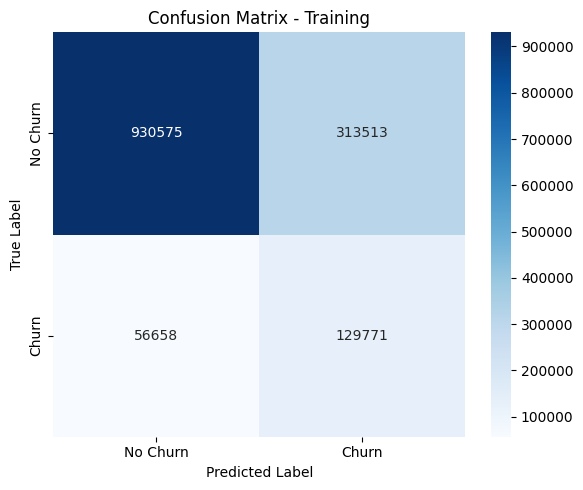


Training Confusion Matrix:
  True Negatives:  930,575
  False Positives: 313,513
  False Negatives: 56,658
  True Positives:  129,771


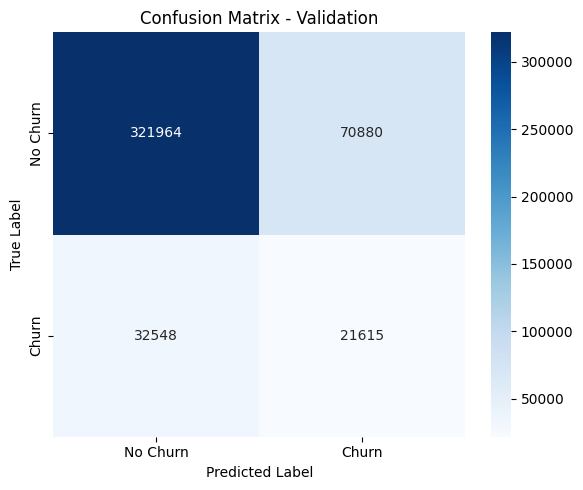


Validation Confusion Matrix:
  True Negatives:  321,964
  False Positives: 70,880
  False Negatives: 32,548
  True Positives:  21,615


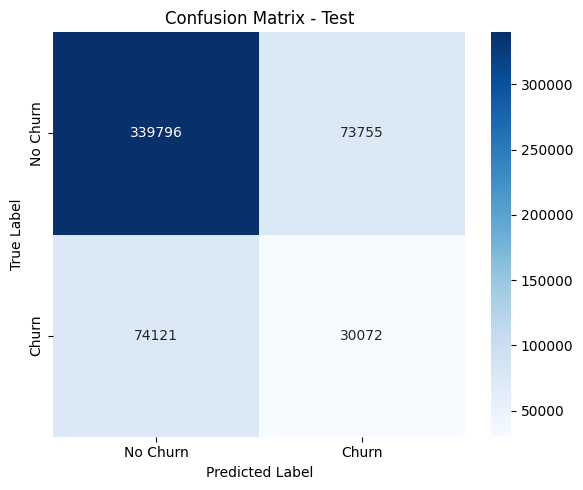


Test Confusion Matrix:
  True Negatives:  339,796
  False Positives: 73,755
  False Negatives: 74,121
  True Positives:  30,072


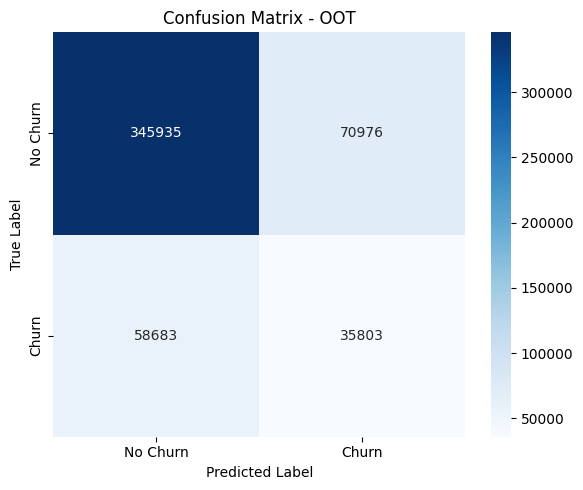


OOT Confusion Matrix:
  True Negatives:  345,935
  False Positives: 70,976
  False Negatives: 58,683
  True Positives:  35,803


In [24]:
# ============================================================================
# STEP 8: CONFUSION MATRICES
# ============================================================================
print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

def plot_confusion_matrix(y_true, y_pred, split_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - {split_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print confusion matrix values
    print(f"\n{split_name} Confusion Matrix:")
    print(f"  True Negatives:  {cm[0, 0]:,}")
    print(f"  False Positives: {cm[0, 1]:,}")
    print(f"  False Negatives: {cm[1, 0]:,}")
    print(f"  True Positives:  {cm[1, 1]:,}")

# Plot confusion matrices for all splits
plot_confusion_matrix(y_train, y_train_pred, "Training")
plot_confusion_matrix(y_val, y_val_pred, "Validation")
plot_confusion_matrix(y_test, y_test_pred, "Test")
plot_confusion_matrix(y_oot, y_oot_pred, "OOT")


TOP 20 MOST IMPORTANT FEATURES

Top 20 features (by absolute coefficient):
                feature  coefficient  abs_coefficient
     last_is_auto_renew    -2.289161         2.289161
    is_missing_activity     1.028774         1.028774
       registered_via_9     0.653331         0.653331
       registered_via_3     0.564452         0.564452
           city_clean_1     0.372028         0.372028
       registered_via_7    -0.366142         0.366142
   days_since_last_play     0.282432         0.282432
          city_clean_16     0.252042         0.252042
is_missing_demographics     0.195318         0.195318
        is_missing_demo     0.157052         0.157052
            sum_secs_w7    -0.149559         0.149559
  engagement_ratio_7_30     0.147160         0.147160
        active_days_w30    -0.146629         0.146629
          city_clean_13    -0.124173         0.124173
          city_clean_11    -0.121702         0.121702
          city_clean_15    -0.117618         0.117618
      

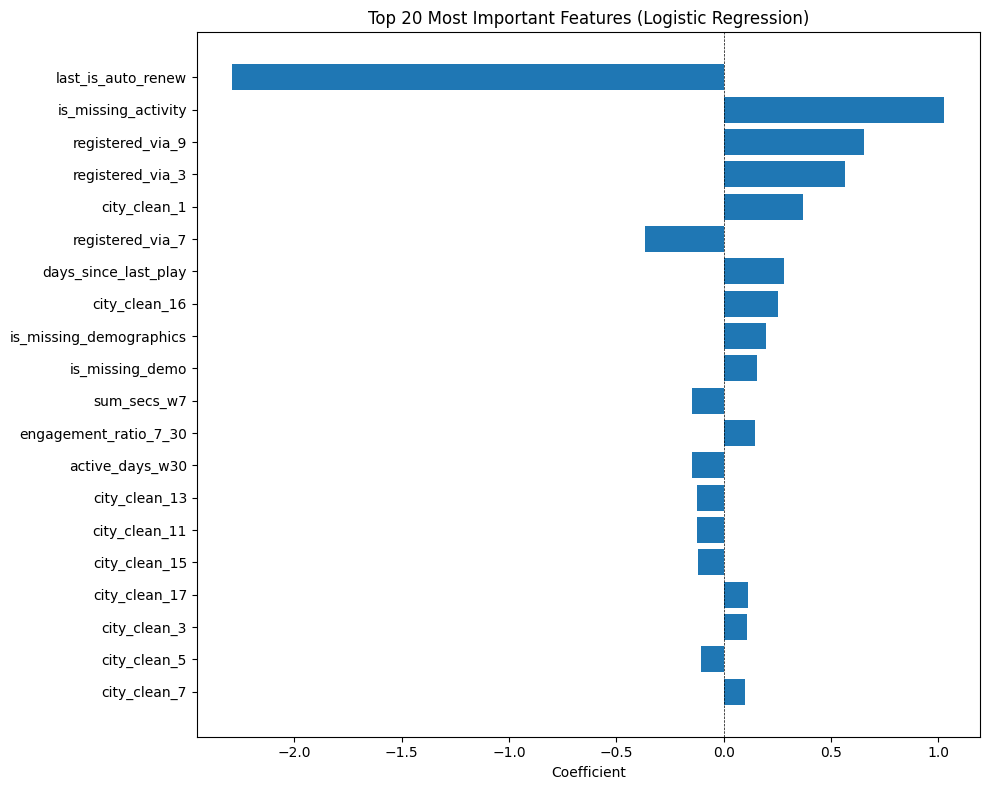

In [25]:
# ============================================================================
# STEP 9: FEATURE IMPORTANCE (COEFFICIENTS)
# ============================================================================
print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)

# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'coefficient': lr_model.coef_[0]
})

# Sort by absolute value
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

# Display top 20 features
print("\nTop 20 features (by absolute coefficient):")
print(feature_importance.head(20).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient')
plt.title('Top 20 Most Important Features (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


[STEP 10] Plotting ROC curves...


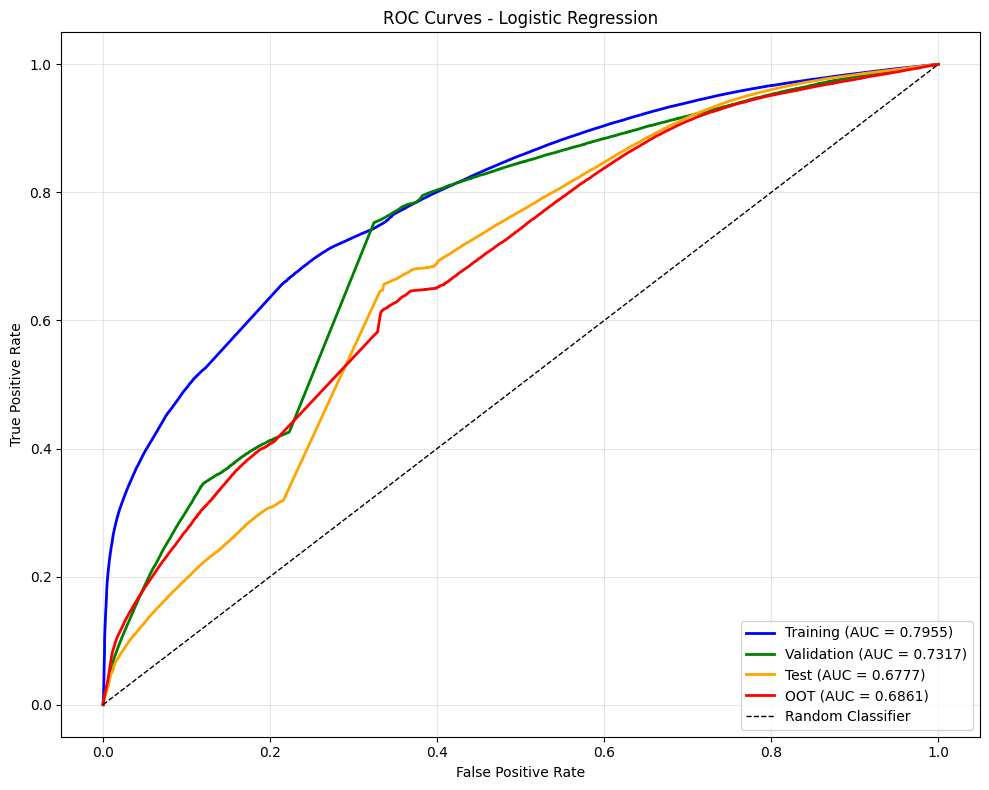

In [26]:
# ============================================================================
# STEP 10: ROC CURVES
# ============================================================================
print("\n[STEP 10] Plotting ROC curves...")

plt.figure(figsize=(10, 8))

# Plot ROC curve for each split
for y_true, y_pred_proba, split_name, color in [
    (y_train, y_train_pred_proba, 'Training', 'blue'),
    (y_val, y_val_pred_proba, 'Validation', 'green'),
    (y_test, y_test_pred_proba, 'Test', 'orange'),
    (y_oot, y_oot_pred_proba, 'OOT', 'red')
]:
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{split_name} (AUC = {auc:.4f})', color=color, linewidth=2)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)

summary_df = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test', 'OOT'],
    'AUC-ROC': [train_metrics[0], val_metrics[0], test_metrics[0], oot_metrics[0]],
    'Precision': [train_metrics[1], val_metrics[1], test_metrics[1], oot_metrics[1]],
    'Recall': [train_metrics[2], val_metrics[2], test_metrics[2], oot_metrics[2]],
    'F1-Score': [train_metrics[3], val_metrics[3], test_metrics[3], oot_metrics[3]]
})

print("\n", summary_df.to_string(index=False))

print("\n" + "="*70)
print("✓ LOGISTIC REGRESSION TRAINING COMPLETE")
print("="*70)


SUMMARY

      Split  AUC-ROC  Precision   Recall  F1-Score
  Training 0.795476   0.292749 0.696088  0.412159
Validation 0.731684   0.233688 0.399073  0.294767
      Test 0.677709   0.289636 0.288618  0.289126
       OOT 0.686145   0.335300 0.378924  0.355780

✓ LOGISTIC REGRESSION TRAINING COMPLETE


In [44]:
import pickle
import os
from datetime import datetime

# ============================================================================
# SAVE LOGISTIC REGRESSION MODEL AND ARTIFACTS
# ============================================================================
print("\n" + "="*70)
print("SAVING LOGISTIC REGRESSION MODEL")
print("="*70)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Prepare model package
model_package = {
    # Core model and preprocessing
    'model': lr_model,
    'scaler': scaler,
    
    # Feature information
    'feature_columns': list(X_train_encoded.columns),
    'numeric_columns': numeric_cols,
    'original_feature_columns': feature_cols,
    
    # Model metadata
    'model_type': 'Logistic Regression',
    'training_date': config['model_train_date_str'],
    'train_start_date': str(config['train_start_date'].date()),
    'train_end_date': str(config['train_end_date'].date()),
    'trained_on': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Performance metrics
    'performance': {
        'train': {
            'auc_roc': train_metrics[0],
            'precision': train_metrics[1],
            'recall': train_metrics[2],
            'f1_score': train_metrics[3]
        },
        'validation': {
            'auc_roc': val_metrics[0],
            'precision': val_metrics[1],
            'recall': val_metrics[2],
            'f1_score': val_metrics[3]
        },
        'test': {
            'auc_roc': test_metrics[0],
            'precision': test_metrics[1],
            'recall': test_metrics[2],
            'f1_score': test_metrics[3]
        },
        'oot': {
            'auc_roc': oot_metrics[0],
            'precision': oot_metrics[1],
            'recall': oot_metrics[2],
            'f1_score': oot_metrics[3]
        }
    },
    
    # Model configuration
    'model_params': lr_model.get_params(),
    
    # Data info
    'train_size': len(X_train),
    'churn_rate': y_train.mean()
}

# Generate filename with timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f"models/lr_churn_model_{timestamp}.pkl"

# Save the model package
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✓ Model saved successfully!")
print(f"  File: {model_filename}")
print(f"  Size: {os.path.getsize(model_filename) / 1024:.2f} KB")

# Also save with a simple name for easy loading
simple_filename = "models/lr_churn_model_latest.pkl"
with open(simple_filename, 'wb') as f:
    pickle.dump(model_package, f)
print(f"  Alias: {simple_filename}")

print("\nModel package contains:")
print("  - Trained Logistic Regression model")
print("  - StandardScaler (fitted)")
print("  - Feature column names")
print("  - Performance metrics (train/val/test/OOT)")
print("  - Training metadata")


SAVING LOGISTIC REGRESSION MODEL
✓ Model saved successfully!
  File: models/lr_churn_model_20251103_122821.pkl
  Size: 3.37 KB
  Alias: models/lr_churn_model_latest.pkl

Model package contains:
  - Trained Logistic Regression model
  - StandardScaler (fitted)
  - Feature column names
  - Performance metrics (train/val/test/OOT)
  - Training metadata


#### XGBoost

In [30]:
# ============================================================================
# STEP 1: VERIFY DATA IS READY
# ============================================================================
print("\n[STEP 1] Verifying preprocessed data...")

# Use the encoded and scaled data from Logistic Regression
# Variable names from your LR script:
# - X_train_encoded, X_val_encoded, X_test_encoded, X_oot_encoded
# - y_train, y_val, y_test, y_oot

print(f"  Train shape: {X_train_encoded.shape}")
print(f"  Val shape: {X_val_encoded.shape}")
print(f"  Test shape: {X_test_encoded.shape}")
print(f"  OOT shape: {X_oot_encoded.shape}")


[STEP 1] Verifying preprocessed data...
  Train shape: (1430517, 38)
  Val shape: (447007, 38)
  Test shape: (517744, 38)
  OOT shape: (511397, 38)


In [31]:
# ============================================================================
# STEP 2: CALCULATE SCALE_POS_WEIGHT FOR CLASS IMBALANCE
# ============================================================================
print("\n[STEP 2] Calculating scale_pos_weight for class imbalance...")

# XGBoost uses scale_pos_weight instead of class_weight
# scale_pos_weight = (# negative samples) / (# positive samples)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
print(f"  (Ratio of non-churners to churners)")


[STEP 2] Calculating scale_pos_weight for class imbalance...
  scale_pos_weight: 6.67
  (Ratio of non-churners to churners)


In [32]:
# ============================================================================
# STEP 3: DEFINE XGBOOST MODEL
# ============================================================================
print("\n[STEP 3] Defining XGBoost classifier...")

xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=88,
    n_jobs=-1,
    tree_method='hist'  # Faster for large datasets
)

print("  ✓ XGBoost classifier initialized")


[STEP 3] Defining XGBoost classifier...
  ✓ XGBoost classifier initialized


In [33]:
# ============================================================================
# STEP 4: DEFINE HYPERPARAMETER SEARCH SPACE
# ============================================================================
print("\n[STEP 4] Defining hyperparameter search space...")

param_dist = {
    'n_estimators': [50, 100, 200],           # Number of trees
    'max_depth': [3, 5, 7],                   # Tree depth
    'learning_rate': [0.01, 0.05, 0.1],       # Step size
    'subsample': [0.6, 0.8, 1.0],             # Sample ratio for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],      # Feature sampling ratio
    'gamma': [0, 0.1, 0.5],                   # Minimum loss reduction
    'min_child_weight': [1, 3, 5],            # Minimum sum of weights in child
    'reg_alpha': [0, 0.1, 1],                 # L1 regularization
    'reg_lambda': [1, 1.5, 2]                 # L2 regularization
}

print(f"  ✓ Search space defined")
print(f"  ✓ Total combinations: {np.prod([len(v) for v in param_dist.values()]):,}")
print(f"  ✓ Random search will test 20 combinations")


[STEP 4] Defining hyperparameter search space...
  ✓ Search space defined
  ✓ Total combinations: 19,683
  ✓ Random search will test 20 combinations


In [34]:
# ============================================================================
# STEP 5: SET UP RANDOMIZED SEARCH WITH CROSS-VALIDATION
# ============================================================================
print("\n[STEP 5] Setting up RandomizedSearchCV...")

# Create AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up random search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=20,              # Test 20 random combinations
    cv=3,                   # 3-fold cross-validation
    verbose=2,              # Show progress
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

print("  ✓ RandomizedSearchCV configured")
print("  ✓ Using 3-fold CV")
print("  ✓ Testing 20 random parameter combinations")


[STEP 5] Setting up RandomizedSearchCV...
  ✓ RandomizedSearchCV configured
  ✓ Using 3-fold CV
  ✓ Testing 20 random parameter combinations


In [35]:
# ============================================================================
# STEP 6: PERFORM HYPERPARAMETER SEARCH
# ============================================================================
print("\n[STEP 6] Running hyperparameter search (this may take 10-20 minutes)...")
print("  (Progress updates will appear below)\n")

# Fit the random search on training data
random_search.fit(X_train_encoded, y_train)

print("\n  ✓ Hyperparameter search complete!")


[STEP 6] Running hyperparameter search (this may take 10-20 minutes)...
  (Progress updates will appear below)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/us


  ✓ Hyperparameter search complete!


In [36]:
# ============================================================================
# STEP 7: DISPLAY BEST PARAMETERS
# ============================================================================
print("\n" + "="*70)
print("BEST HYPERPARAMETERS FOUND")
print("="*70)

print("\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation AUC score: {random_search.best_score_:.4f}")


BEST HYPERPARAMETERS FOUND

Best parameters:
  subsample: 0.6
  reg_lambda: 1
  reg_alpha: 0
  n_estimators: 50
  min_child_weight: 1
  max_depth: 7
  learning_rate: 0.01
  gamma: 0.1
  colsample_bytree: 1.0

Best cross-validation AUC score: nan


In [37]:
# ============================================================================
# STEP 8: GET BEST MODEL AND MAKE PREDICTIONS
# ============================================================================
print("\n[STEP 8] Making predictions with best model...")

best_model = random_search.best_estimator_

# Predict probabilities for all splits
y_train_pred_proba = best_model.predict_proba(X_train_encoded)[:, 1]
y_val_pred_proba = best_model.predict_proba(X_val_encoded)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_encoded)[:, 1]
y_oot_pred_proba = best_model.predict_proba(X_oot_encoded)[:, 1]

# Predict classes
y_train_pred = best_model.predict(X_train_encoded)
y_val_pred = best_model.predict(X_val_encoded)
y_test_pred = best_model.predict(X_test_encoded)
y_oot_pred = best_model.predict(X_oot_encoded)

print("  ✓ Predictions generated for all splits")


[STEP 8] Making predictions with best model...
  ✓ Predictions generated for all splits


In [38]:
# ============================================================================
# STEP 9: EVALUATE PERFORMANCE
# ============================================================================
print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)

def evaluate_split_xgb(y_true, y_pred, y_pred_proba, split_name):
    """Evaluate XGBoost performance on a split"""
    from sklearn.metrics import precision_recall_fscore_support
    
    # Calculate metrics
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='binary', zero_division=0
    )
    
    print(f"\n{split_name} Set:")
    print(f"  AUC-ROC:   {auc_roc:.4f}")
    print(f"  GINI:      {gini:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return auc_roc, gini, precision, recall, f1

# Evaluate all splits
train_metrics = evaluate_split_xgb(y_train, y_train_pred, y_train_pred_proba, "Training")
val_metrics = evaluate_split_xgb(y_val, y_val_pred, y_val_pred_proba, "Validation")
test_metrics = evaluate_split_xgb(y_test, y_test_pred, y_test_pred_proba, "Test")
oot_metrics = evaluate_split_xgb(y_oot, y_oot_pred, y_oot_pred_proba, "OOT")


MODEL PERFORMANCE METRICS

Training Set:
  AUC-ROC:   0.8145
  GINI:      0.6289
  Precision: 0.3113
  Recall:    0.6977
  F1-Score:  0.4305

Validation Set:
  AUC-ROC:   0.7475
  GINI:      0.4951
  Precision: 0.2479
  Recall:    0.7813
  F1-Score:  0.3764

Test Set:
  AUC-ROC:   0.6574
  GINI:      0.3148
  Precision: 0.2991
  Recall:    0.6725
  F1-Score:  0.4140

OOT Set:
  AUC-ROC:   0.6167
  GINI:      0.2333
  Precision: 0.2332
  Recall:    0.6089
  F1-Score:  0.3372



CONFUSION MATRICES


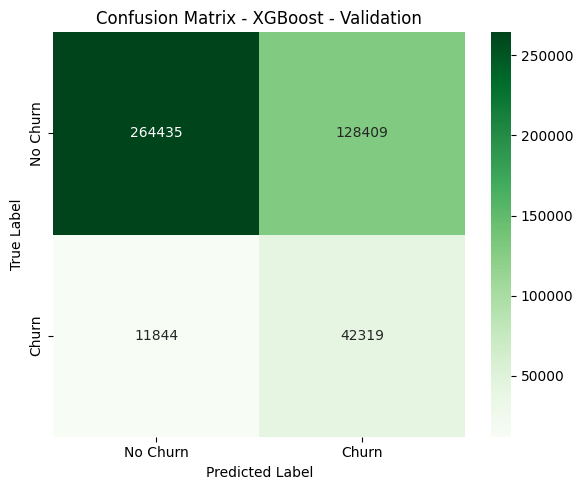


Validation Confusion Matrix:
  True Negatives:  264,435
  False Positives: 128,409
  False Negatives: 11,844
  True Positives:  42,319


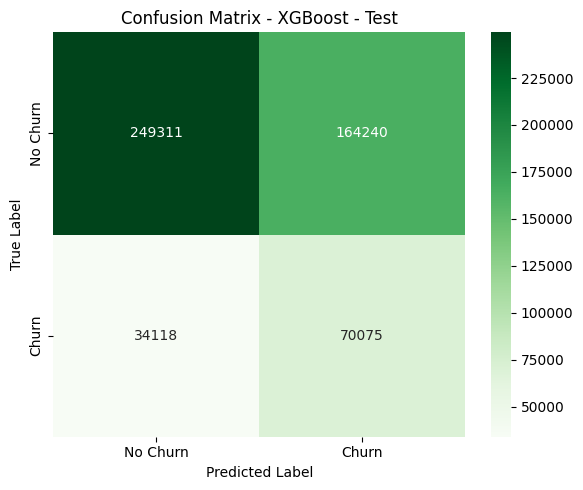


Test Confusion Matrix:
  True Negatives:  249,311
  False Positives: 164,240
  False Negatives: 34,118
  True Positives:  70,075


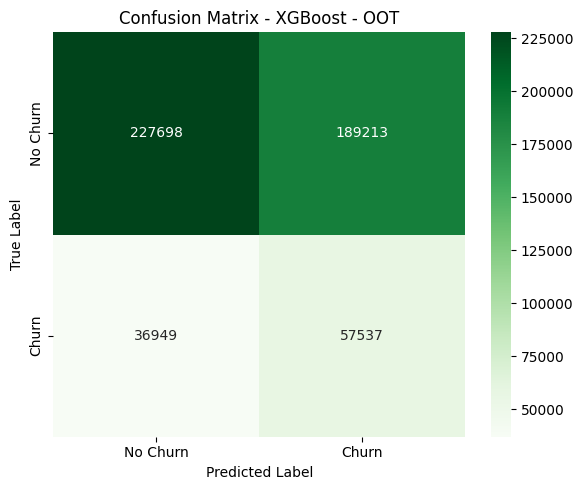


OOT Confusion Matrix:
  True Negatives:  227,698
  False Positives: 189,213
  False Negatives: 36,949
  True Positives:  57,537


In [39]:
# ============================================================================
# STEP 10: CONFUSION MATRICES
# ============================================================================
print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

def plot_confusion_matrix_xgb(y_true, y_pred, split_name):
    """Plot confusion matrix for XGBoost"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - XGBoost - {split_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{split_name} Confusion Matrix:")
    print(f"  True Negatives:  {cm[0, 0]:,}")
    print(f"  False Positives: {cm[0, 1]:,}")
    print(f"  False Negatives: {cm[1, 0]:,}")
    print(f"  True Positives:  {cm[1, 1]:,}")

# Plot confusion matrices
plot_confusion_matrix_xgb(y_val, y_val_pred, "Validation")
plot_confusion_matrix_xgb(y_test, y_test_pred, "Test")
plot_confusion_matrix_xgb(y_oot, y_oot_pred, "OOT")


TOP 20 MOST IMPORTANT FEATURES

Top 20 features (by importance):
                feature  importance
     last_is_auto_renew    0.916870
            sum_secs_w7    0.023910
       registered_via_7    0.017822
       registered_via_9    0.014140
       registered_via_3    0.007316
           sum_secs_w30    0.007012
tenure_days_at_snapshot    0.004560
  engagement_ratio_7_30    0.001622
   days_since_last_play    0.001017
           city_clean_1    0.001009
        active_days_w30    0.000770
      complete_rate_w30    0.000640
           city_clean_9    0.000494
           city_clean_5    0.000300
           city_clean_4    0.000281
       auto_renew_share    0.000268
         trend_secs_w30    0.000221
           city_clean_7    0.000208
          city_clean_16    0.000206
           city_clean_3    0.000197


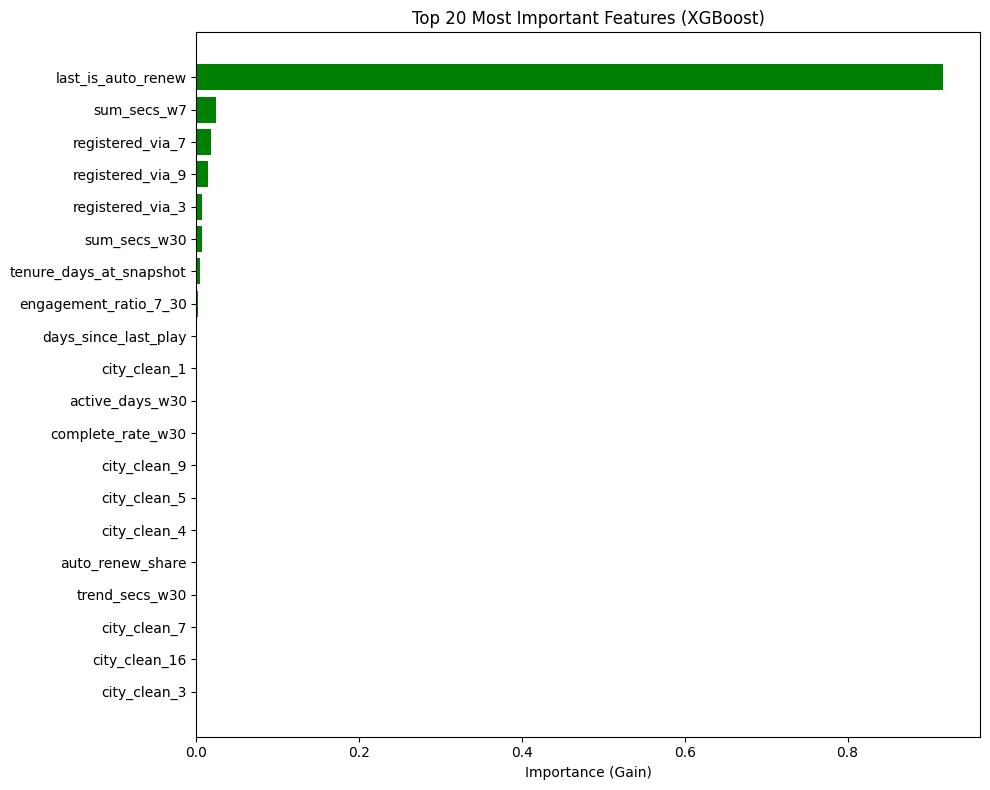

In [41]:
# ============================================================================
# STEP 11: FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': best_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display top 20
print("\nTop 20 features (by importance):")
print(feature_importance.head(20).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='green')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [40]:
# ============================================================================
# STEP 12: SUMMARY TABLE
# ============================================================================
print("\n" + "="*70)
print("SUMMARY - XGBOOST PERFORMANCE")
print("="*70)

summary_df = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test', 'OOT'],
    'AUC-ROC': [train_metrics[0], val_metrics[0], test_metrics[0], oot_metrics[0]],
    'GINI': [train_metrics[1], val_metrics[1], test_metrics[1], oot_metrics[1]],
    'Precision': [train_metrics[2], val_metrics[2], test_metrics[2], oot_metrics[2]],
    'Recall': [train_metrics[3], val_metrics[3], test_metrics[3], oot_metrics[3]],
    'F1-Score': [train_metrics[4], val_metrics[4], test_metrics[4], oot_metrics[4]]
})

print("\n", summary_df.to_string(index=False))


SUMMARY - XGBOOST PERFORMANCE

      Split  AUC-ROC     GINI  Precision   Recall  F1-Score
  Training 0.814464 0.628928   0.311302 0.697713  0.430518
Validation 0.747543 0.495085   0.247874 0.781327  0.376351
      Test 0.657409 0.314818   0.299063 0.672550  0.414023
       OOT 0.616670 0.233340   0.233179 0.608947  0.337227


In [42]:
# ============================================================================
# STEP 13: COMPARE WITH LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: XGBOOST vs LOGISTIC REGRESSION")
print("="*70)

# Assuming you saved LR results, manually enter them here for comparison
# Or you can save LR metrics to variables earlier
print("\nManual comparison with your LR results:")
print("Metric         | Logistic Regression | XGBoost")
print("---------------|---------------------|----------")
print(f"Val AUC-ROC    | 0.7317              | {val_metrics[0]:.4f}")
print(f"Test AUC-ROC   | 0.6777              | {test_metrics[0]:.4f}")
print(f"OOT AUC-ROC    | 0.6861              | {oot_metrics[0]:.4f}")

# Calculate improvement
val_improvement = (val_metrics[0] - 0.7317) / 0.7317 * 100
test_improvement = (test_metrics[0] - 0.6777) / 0.6777 * 100
oot_improvement = (oot_metrics[0] - 0.6861) / 0.6861 * 100

print(f"\nImprovement:")
print(f"Val:  {val_improvement:+.2f}%")
print(f"Test: {test_improvement:+.2f}%")
print(f"OOT:  {oot_improvement:+.2f}%")

print("\n" + "="*70)
print("✓ XGBOOST TRAINING COMPLETE")
print("="*70)


COMPARISON: XGBOOST vs LOGISTIC REGRESSION

Manual comparison with your LR results:
Metric         | Logistic Regression | XGBoost
---------------|---------------------|----------
Val AUC-ROC    | 0.7317              | 0.7475
Test AUC-ROC   | 0.6777              | 0.6574
OOT AUC-ROC    | 0.6861              | 0.6167

Improvement:
Val:  +2.17%
Test: -2.99%
OOT:  -10.12%

✓ XGBOOST TRAINING COMPLETE
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=2, subsample=1.0; total time=  43.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=  41.0s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, reg_alpha=0, reg_lambda=1, subsample=1.0; total time=  22.9s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.05, max_depth=7, min_

In [45]:
# ============================================================================
# SAVE XGBOOST (after you train it)
# ============================================================================
xgb_package = {
    'model': best_model,  # from RandomizedSearchCV
    'scaler': scaler,     # same scaler as LR
    'feature_columns': list(X_train_encoded.columns),
    'numeric_columns': numeric_cols,
    'model_type': 'XGBoost',
    'best_params': random_search.best_params_,
    'performance': {
        'oot_auc': oot_metrics[0]  # XGBoost OOT AUC
    }
}

with open(f'models/xgb_model_{timestamp}.pkl', 'wb') as f:
    pickle.dump(xgb_package, f)
print("✓ XGBoost saved")

✓ XGBoost saved


#### Random Forest

In [ ]:
# ============================================================================
# STEP 0: SETUP MLFLOW (OPTIONAL - UNCOMMENT IF USING MLFLOW)
# ============================================================================
# For local MLflow (default)
mlflow.set_tracking_uri("file:./mlruns")

# For Docker MLflow (uncomment if using Docker)
# mlflow.set_tracking_uri("http://localhost:5000")

# Set experiment name
mlflow.set_experiment("KKBox_Churn_Prediction")

print("\n[MLflow] Tracking URI:", mlflow.get_tracking_uri())
print("[MLflow] Experiment:", mlflow.get_experiment_by_name("KKBox_Churn_Prediction"))

In [48]:
# ============================================================================
# STEP 1: VERIFY DATA IS READY
# ============================================================================
print("\n[STEP 1] Verifying preprocessed data...")

# Use the encoded and scaled data from Logistic Regression
print(f"  Train shape: {X_train_encoded.shape}")
print(f"  Val shape: {X_val_encoded.shape}")
print(f"  Test shape: {X_test_encoded.shape}")
print(f"  OOT shape: {X_oot_encoded.shape}")


[STEP 1] Verifying preprocessed data...
  Train shape: (1430517, 38)
  Val shape: (447007, 38)
  Test shape: (517744, 38)
  OOT shape: (511397, 38)


In [49]:
# ============================================================================
# STEP 2: CALCULATE CLASS WEIGHT FOR IMBALANCE
# ============================================================================
print("\n[STEP 2] Calculating class weights for imbalance handling...")

# Calculate class weights
n_samples = len(y_train)
n_negative = (y_train == 0).sum()
n_positive = (y_train == 1).sum()
weight_for_0 = n_samples / (2 * n_negative)
weight_for_1 = n_samples / (2 * n_positive)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"  Class 0 (No Churn) weight: {weight_for_0:.4f}")
print(f"  Class 1 (Churn) weight: {weight_for_1:.4f}")
print(f"  Churn rate: {y_train.mean():.2%}")


[STEP 2] Calculating class weights for imbalance handling...
  Class 0 (No Churn) weight: 0.5749
  Class 1 (Churn) weight: 3.8366
  Churn rate: 13.03%


In [50]:
# ============================================================================
# STEP 3: DEFINE RANDOM FOREST MODEL
# ============================================================================
print("\n[STEP 3] Defining Random Forest classifier...")

rf_clf = RandomForestClassifier(
    class_weight=class_weight,  # Handle class imbalance
    random_state=88,
    n_jobs=-1,                  # Use all CPU cores
    verbose=0
)

print("  ✓ Random Forest classifier initialized")


[STEP 3] Defining Random Forest classifier...
  ✓ Random Forest classifier initialized


In [51]:
# ============================================================================
# STEP 4: DEFINE HYPERPARAMETER SEARCH SPACE
# ============================================================================
print("\n[STEP 4] Defining hyperparameter search space...")

param_dist = {
    'n_estimators': [100, 200, 300],              # Number of trees
    'max_depth': [10, 20, 30, None],              # Tree depth (None = unlimited)
    'min_samples_split': [2, 5, 10],              # Min samples to split node
    'min_samples_leaf': [1, 2, 4],                # Min samples in leaf
    'max_features': ['sqrt', 'log2', None],       # Features to consider for split
    'bootstrap': [True, False],                   # Bootstrap samples
    'max_samples': [0.7, 0.8, 0.9, None]         # If bootstrap=True, sample size
}

print(f"  ✓ Search space defined")
print(f"  ✓ Total combinations: {np.prod([len(v) for v in param_dist.values()]):,}")
print(f"  ✓ Random search will test 20 combinations")


[STEP 4] Defining hyperparameter search space...
  ✓ Search space defined
  ✓ Total combinations: 2,592
  ✓ Random search will test 20 combinations


In [52]:
# ============================================================================
# STEP 5: SET UP RANDOMIZED SEARCH WITH CROSS-VALIDATION
# ============================================================================
print("\n[STEP 5] Setting up RandomizedSearchCV...")

# Create AUC scorer
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Set up random search
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=20,              # Test 20 random combinations
    cv=3,                   # 3-fold cross-validation
    verbose=2,              # Show progress
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    return_train_score=True
)

print("  ✓ RandomizedSearchCV configured")
print("  ✓ Using 3-fold CV")
print("  ✓ Testing 20 random parameter combinations")


[STEP 5] Setting up RandomizedSearchCV...
  ✓ RandomizedSearchCV configured
  ✓ Using 3-fold CV
  ✓ Testing 20 random parameter combinations


In [53]:
# ============================================================================
# STEP 6: PERFORM HYPERPARAMETER SEARCH WITH MLFLOW
# ============================================================================
print("\n[STEP 6] Running hyperparameter search (this may take 15-30 minutes)...")
print("  (Progress updates will appear below)\n")

# Start MLflow run
with mlflow.start_run(run_name="RandomForest_Tuning") as run:
    
    # Log that we're doing hyperparameter tuning
    mlflow.log_param("model_type", "Random Forest")
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("cv_folds", 3)
    mlflow.log_param("n_iter", 20)
    mlflow.log_param("class_weight", "balanced")
    
    # Fit the random search on training data
    random_search.fit(X_train_encoded, y_train)
    
    print("\n  ✓ Hyperparameter search complete!")
    
    # ============================================================================
    # STEP 7: LOG BEST PARAMETERS TO MLFLOW
    # ============================================================================
    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS FOUND")
    print("="*70)
    
    print("\nBest parameters:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
        mlflow.log_param(f"best_{param}", value)
    
    best_cv_score = random_search.best_score_
    print(f"\nBest cross-validation AUC score: {best_cv_score:.4f}")
    mlflow.log_metric("cv_auc_score", best_cv_score)
    
    # ============================================================================
    # STEP 8: GET BEST MODEL AND MAKE PREDICTIONS
    # ============================================================================
    print("\n[STEP 8] Making predictions with best model...")
    
    best_model = random_search.best_estimator_
    
    # Predict probabilities for all splits
    y_train_pred_proba = best_model.predict_proba(X_train_encoded)[:, 1]
    y_val_pred_proba = best_model.predict_proba(X_val_encoded)[:, 1]
    y_test_pred_proba = best_model.predict_proba(X_test_encoded)[:, 1]
    y_oot_pred_proba = best_model.predict_proba(X_oot_encoded)[:, 1]
    
    # Predict classes
    y_train_pred = best_model.predict(X_train_encoded)
    y_val_pred = best_model.predict(X_val_encoded)
    y_test_pred = best_model.predict(X_test_encoded)
    y_oot_pred = best_model.predict(X_oot_encoded)
    
    print("  ✓ Predictions generated for all splits")
    
    # ============================================================================
    # STEP 9: EVALUATE PERFORMANCE AND LOG TO MLFLOW
    # ============================================================================
    print("\n" + "="*70)
    print("MODEL PERFORMANCE METRICS")
    print("="*70)
    
    def evaluate_split_rf(y_true, y_pred, y_pred_proba, split_name):
        """Evaluate Random Forest performance on a split"""
        
        # Calculate metrics
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        gini = 2 * auc_roc - 1
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )
        
        print(f"\n{split_name} Set:")
        print(f"  AUC-ROC:   {auc_roc:.4f}")
        print(f"  GINI:      {gini:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        
        # Log to MLflow
        mlflow.log_metric(f"{split_name.lower()}_auc", auc_roc)
        mlflow.log_metric(f"{split_name.lower()}_gini", gini)
        mlflow.log_metric(f"{split_name.lower()}_precision", precision)
        mlflow.log_metric(f"{split_name.lower()}_recall", recall)
        mlflow.log_metric(f"{split_name.lower()}_f1", f1)
        
        return auc_roc, gini, precision, recall, f1
    
    # Evaluate all splits
    train_metrics = evaluate_split_rf(y_train, y_train_pred, y_train_pred_proba, "Training")
    val_metrics = evaluate_split_rf(y_val, y_val_pred, y_val_pred_proba, "Validation")
    test_metrics = evaluate_split_rf(y_test, y_test_pred, y_test_pred_proba, "Test")
    oot_metrics = evaluate_split_rf(y_oot, y_oot_pred, y_oot_pred_proba, "OOT")
    
    # ============================================================================
    # STEP 10: LOG MODEL TO MLFLOW
    # ============================================================================
    print("\n[STEP 10] Logging model to MLflow...")
    
    # Log the model
    mlflow.sklearn.log_model(
        best_model, 
        "random_forest_model",
        registered_model_name="RandomForest_Churn_Predictor"
    )
    
    # Log additional artifacts
    mlflow.log_param("n_features", X_train_encoded.shape[1])
    mlflow.log_param("train_size", len(X_train))
    mlflow.log_param("churn_rate", y_train.mean())
    
    print("  ✓ Model logged to MLflow")
    print(f"  ✓ Run ID: {run.info.run_id}")


[STEP 6] Running hyperparameter search (this may take 15-30 minutes)...
  (Progress updates will appear below)



NameError: name 'mlflow' is not defined


CONFUSION MATRICES


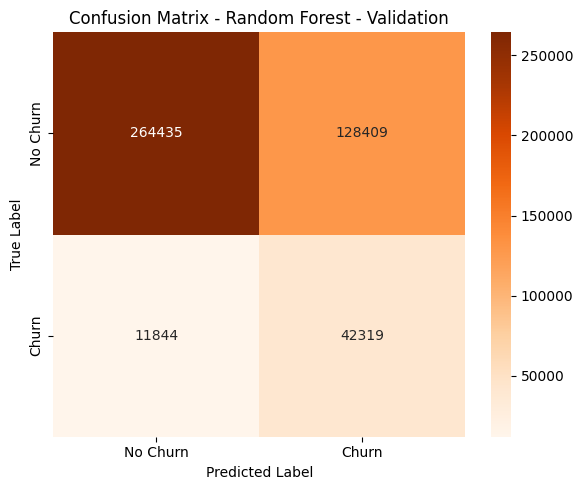


Validation Confusion Matrix:
  True Negatives:  264,435
  False Positives: 128,409
  False Negatives: 11,844
  True Positives:  42,319


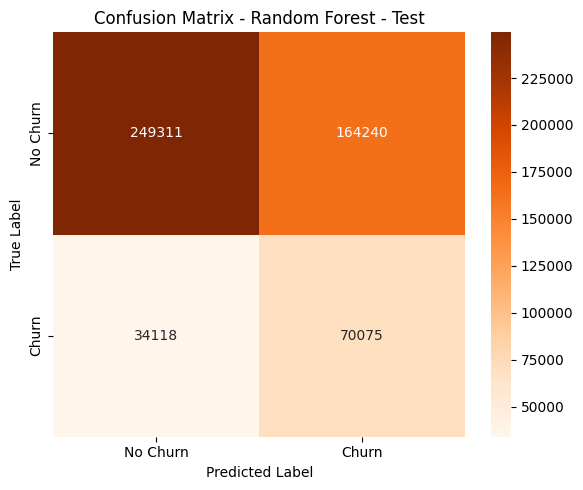


Test Confusion Matrix:
  True Negatives:  249,311
  False Positives: 164,240
  False Negatives: 34,118
  True Positives:  70,075


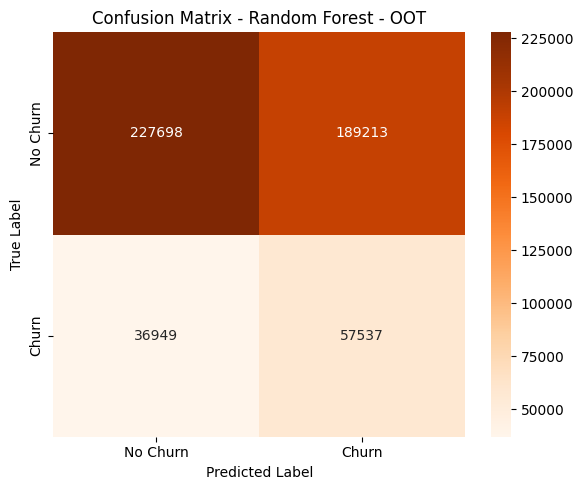


OOT Confusion Matrix:
  True Negatives:  227,698
  False Positives: 189,213
  False Negatives: 36,949
  True Positives:  57,537


In [54]:
# ============================================================================
# STEP 11: CONFUSION MATRICES
# ============================================================================
print("\n" + "="*70)
print("CONFUSION MATRICES")
print("="*70)

def plot_confusion_matrix_rf(y_true, y_pred, split_name):
    """Plot confusion matrix for Random Forest"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Confusion Matrix - Random Forest - {split_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{split_name} Confusion Matrix:")
    print(f"  True Negatives:  {cm[0, 0]:,}")
    print(f"  False Positives: {cm[0, 1]:,}")
    print(f"  False Negatives: {cm[1, 0]:,}")
    print(f"  True Positives:  {cm[1, 1]:,}")

# Plot confusion matrices
plot_confusion_matrix_rf(y_val, y_val_pred, "Validation")
plot_confusion_matrix_rf(y_test, y_test_pred, "Test")
plot_confusion_matrix_rf(y_oot, y_oot_pred, "OOT")


TOP 20 MOST IMPORTANT FEATURES

Top 20 features (by importance):
                feature  importance
     last_is_auto_renew    0.916870
            sum_secs_w7    0.023910
       registered_via_7    0.017822
       registered_via_9    0.014140
       registered_via_3    0.007316
           sum_secs_w30    0.007012
tenure_days_at_snapshot    0.004560
  engagement_ratio_7_30    0.001622
   days_since_last_play    0.001017
           city_clean_1    0.001009
        active_days_w30    0.000770
      complete_rate_w30    0.000640
           city_clean_9    0.000494
           city_clean_5    0.000300
           city_clean_4    0.000281
       auto_renew_share    0.000268
         trend_secs_w30    0.000221
           city_clean_7    0.000208
          city_clean_16    0.000206
           city_clean_3    0.000197


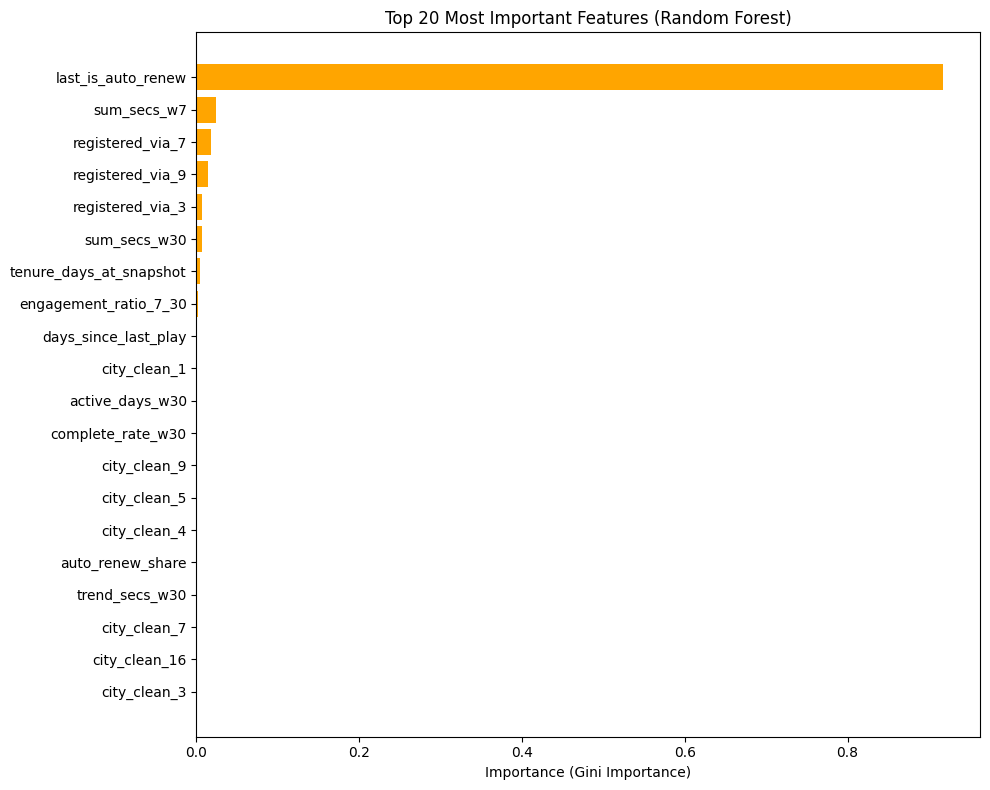

In [55]:
# ============================================================================
# STEP 12: FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*70)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*70)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_encoded.columns,
    'importance': best_model.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display top 20
print("\nTop 20 features (by importance):")
print(feature_importance.head(20).to_string(index=False))

# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='orange')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gini Importance)')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


[STEP 13] Plotting ROC curves...


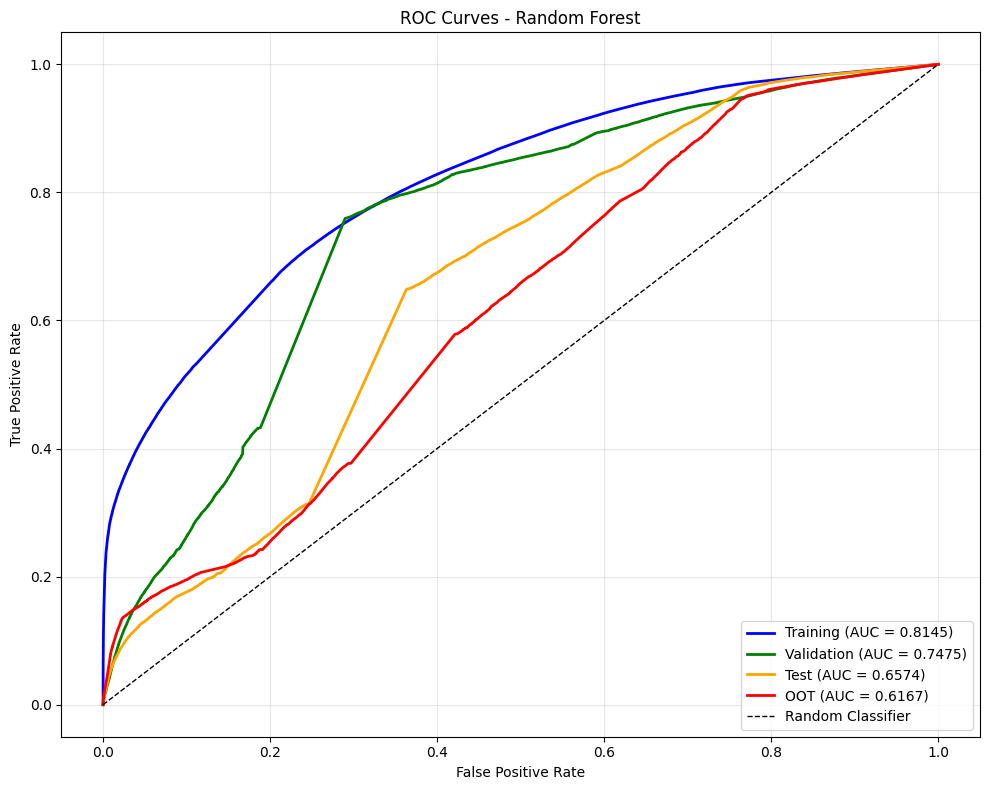

In [56]:
# ============================================================================
# STEP 13: ROC CURVES
# ============================================================================
print("\n[STEP 13] Plotting ROC curves...")

plt.figure(figsize=(10, 8))

# Plot ROC curve for each split
for y_true, y_pred_proba, split_name, color in [
    (y_train, y_train_pred_proba, 'Training', 'blue'),
    (y_val, y_val_pred_proba, 'Validation', 'green'),
    (y_test, y_test_pred_proba, 'Test', 'orange'),
    (y_oot, y_oot_pred_proba, 'OOT', 'red')
]:
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{split_name} (AUC = {auc:.4f})', color=color, linewidth=2)

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Random Forest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [57]:
# ============================================================================
# STEP 14: SUMMARY TABLE
# ============================================================================
print("\n" + "="*70)
print("SUMMARY - RANDOM FOREST PERFORMANCE")
print("="*70)
 
summary_df = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test', 'OOT'],
    'AUC-ROC': [train_metrics[0], val_metrics[0], test_metrics[0], oot_metrics[0]],
    'GINI': [train_metrics[1], val_metrics[1], test_metrics[1], oot_metrics[1]],
    'Precision': [train_metrics[2], val_metrics[2], test_metrics[2], oot_metrics[2]],
    'Recall': [train_metrics[3], val_metrics[3], test_metrics[3], oot_metrics[3]],
    'F1-Score': [train_metrics[4], val_metrics[4], test_metrics[4], oot_metrics[4]]
})

print("\n", summary_df.to_string(index=False))


SUMMARY - RANDOM FOREST PERFORMANCE

      Split  AUC-ROC     GINI  Precision   Recall  F1-Score
  Training 0.814464 0.628928   0.311302 0.697713  0.430518
Validation 0.747543 0.495085   0.247874 0.781327  0.376351
      Test 0.657409 0.314818   0.299063 0.672550  0.414023
       OOT 0.616670 0.233340   0.233179 0.608947  0.337227


In [60]:
# ============================================================================
# STEP 15: COMPARE WITH PREVIOUS MODELS
# ============================================================================
print("\n" + "="*70)
print("COMPARISON: RANDOM FOREST vs OTHER MODELS")
print("="*70)

# Manually enter your previous results for comparison
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Random Forest'],
    'Val AUC': [0.7317, 0.7475, val_metrics[0]],  # Fill in XGBoost after you run it
    'Test AUC': [0.6777, 0.657409, test_metrics[0]],
    'OOT AUC': [0.6861, 0.6166, oot_metrics[0]]
})

print("\n", comparison_df.to_string(index=False))

print("\n" + "="*70)
print("✓ RANDOM FOREST TRAINING COMPLETE")
print("="*70)


COMPARISON: RANDOM FOREST vs OTHER MODELS

               Model  Val AUC  Test AUC  OOT AUC
Logistic Regression 0.731700  0.677700  0.68610
            XGBoost 0.747500  0.657409  0.61660
      Random Forest 0.747543  0.657409  0.61667

✓ RANDOM FOREST TRAINING COMPLETE


In [ ]:
print("\n[Next Steps]")
print("1. Check MLflow UI at http://localhost:5000")
print("2. Compare Random Forest with Logistic Regression and XGBoost")
print("3. Select best model based on OOT AUC score")

In [61]:
spark.stop()